# Code for the Hyperspectral Image Denoising via Matrix Factorization and Deep Prior Regularization Paper

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers, models
from keras.models import Model, load_model
from keras.layers import Input, Conv3D, Dense, BatchNormalization, Concatenate
from keras.callbacks import ModelCheckpoint

import matplotlib.pyplot as plt

%matplotlib inline

# set seed for reproducibility
tf.random.set_seed(42)

In [ ]:
# optional line of code  (can comment out if you don't need it)
devices = tf.config.experimental.list_physical_devices("GPU")
tf.config.experimental.set_memory_growth(devices[0], enable=True)

Initializations of:
- M and N = size of image
- L = spectral bands of image
- X = image
- sigma = standard deviation
- N = white gaussain noise
- S = sparse noise

In [ ]:
# please note that the values of M, N, L might be changed in the future
M, N, L = 512, 512, 640

# M*N hyperspectral image with L spectral bands
X = tf.random.uniform(shape=([M,N,L]), minval=-1, maxval=1, 
                      dtype=tf.float32, seed=42, name='X')

# white Gaussian noise N(0, sigma**2)
# sigma = 
# N = 

# sparse noise
# S = np.random.default_rng().laplace(, , 1000)

In [ ]:
PATH = '/content/indian_pine_array.npy'
data = np.load(PATH)
dataset = tf.convert_to_tensor(data, dtype='uint16')
dataset.shape

TensorShape([145, 145, 200])

- 145 by 145 is the image size. 
- 200 is the number of channels.

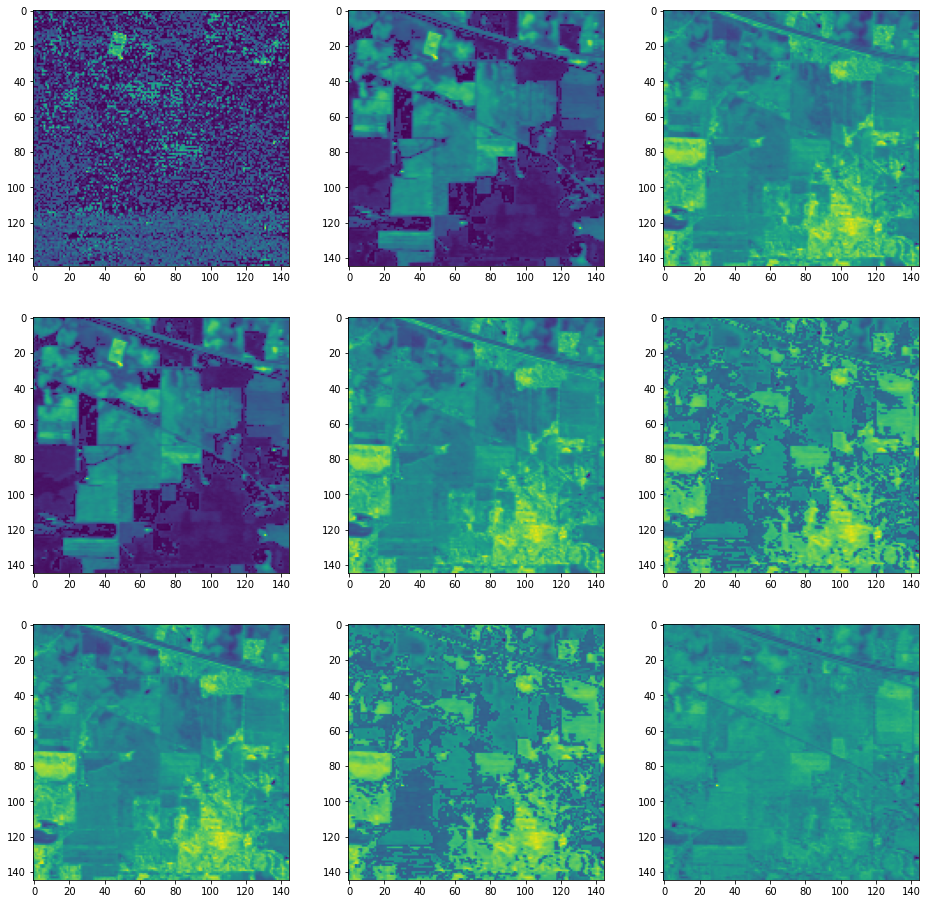

In [ ]:
# Visualizing some images
fig, axes = plt.subplots(3,3, figsize=(16,16))
for i in range(3):
    for j in range(3):
        axes[i,j].imshow(dataset[:, :, (i+j)*20]);

**The noise for this dataset is very low. Must add more noise. Check paper for accurate implementation.**

In [ ]:
# noise for our data
np.random.normal(loc=0., scale=1., size=dataset.shape).shape

In [ ]:
# Let's add some noise to our images  
# Subject to change as per the noise requirements given in the paper
noise = np.random.normal(loc=0., scale=1., size=dataset.shape)
noise_factor = 0.1
X = dataset + noise_factor*noise    # noisy data
Y = dataset                         # denoised data, ie, original data

In [ ]:
# X is the data we'll feed to our model
# Y is the target which our model will learn from
print(X.shape, Y.shape, sep='\n\n')

(145, 145, 200)

(145, 145, 200)


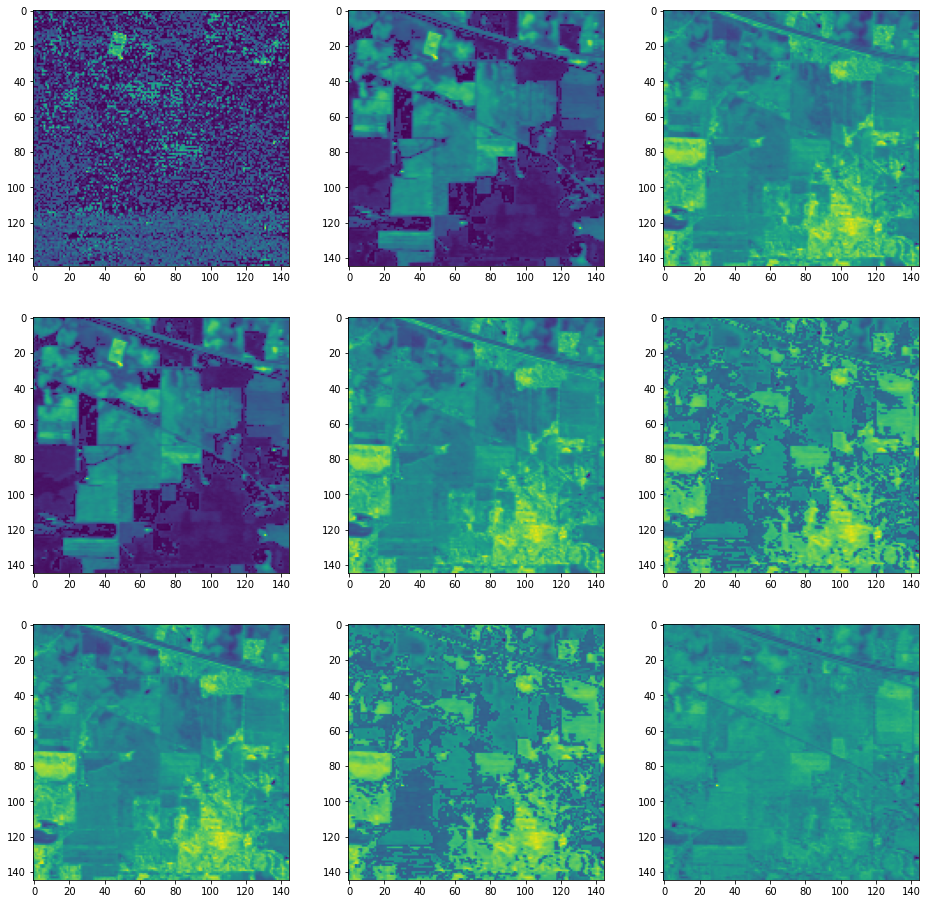

In [ ]:
# Visualize noisy data
fig, axes = plt.subplots(3, 3, figsize=(16,16))
for i in range(3):
    for j in range(3):
        axes[i,j].imshow(X[:, :, (i+j)*20]);

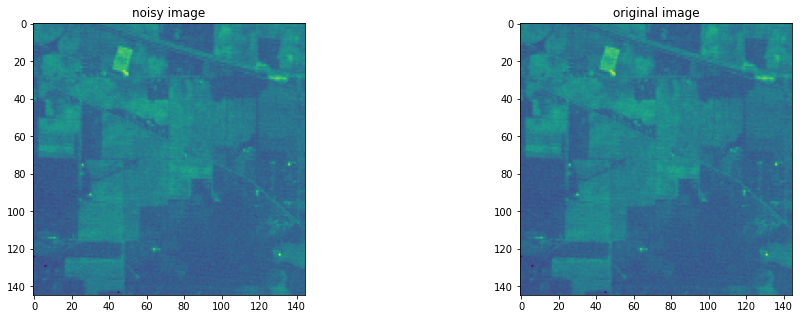

In [ ]:
# Let's take one image and compare its original version with its noisy version side by side
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# noisy image
axes[0].imshow(X[:, :, 3])
axes[0].set_title('noisy image')

# original image
axes[1].imshow(Y[:, :, 3])
axes[1].set_title('original image');

# Model Architecture

**I'm using functional API, as subclassing API is giving errors...**

In [ ]:
a = np.random.rand(1,2,3)
b = np.random.rand(1,2,4)
Concatenate(axis=-1)([a,b])

<tf.Tensor: shape=(1, 2, 7), dtype=float32, numpy=
array([[[0.14969799, 0.5818814 , 0.33709663, 0.7815412 , 0.608036  ,
         0.52675104, 0.4701548 ],
        [0.43990275, 0.16061476, 0.00949638, 0.5600372 , 0.09987282,
         0.777958  , 0.27935213]]], dtype=float32)>

In [ ]:
# M, N, L = dataset.shape
# M, N, L

In [ ]:
# Input as specified in the paper
# M, N, L = 180, 180, 1   # these are the values mentioned in the paper
input_shape = (400, M, N, L)
input_layer = Input(shape=input_shape)

# Model starts
model_input = input_layer
# Block 1
x = Conv3D(filters=64, kernel_size=(3,3,1), activation='relu', padding='same', strides=1, 
           dilation_rate=1, name='block1')(model_input)
x = BatchNormalization()(x)
# Block 2
x = Conv3D(filters=64, kernel_size=(3,3,64), activation='relu', padding='same', strides=1, 
           dilation_rate=2, name='block2')(x)
x = BatchNormalization()(x)
# Block 3
x = Conv3D(filters=64, kernel_size=(3,3,64), activation='relu', padding='same', strides=1,
           dilation_rate=4, name='block3')(x)
x = BatchNormalization()(x)
# Block 4
x = Conv3D(filters=64, kernel_size=(3,3,64), activation='relu', padding='same', strides=1,
           dilation_rate=3, name='block4')(x)
x = BatchNormalization()(x)
# Block 5
x = Conv3D(filters=64, kernel_size=(3,3,64), activation='relu', padding='same', strides=1,
           dilation_rate=4, name='block5')(x)
x = BatchNormalization()(x)
# Block 6
x = Conv3D(filters=64, kernel_size=(3,3,64), activation='relu', padding='same', strides=1,
           dilation_rate=2, name='block6')(x)
x = BatchNormalization()(x)
# Block 7
x = Conv3D(filters=64, kernel_size=(3,3,64), activation='relu', padding='same', strides=1,
           dilation_rate=1, name='block7')(x)
# Skip Connection
x = Concatenate(axis=-1)([x, input_layer])
output = BatchNormalization()(x)

In [ ]:
mymodel = Model(model_input, output)
mymodel.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_18 (InputLayer)          [(None, None, 145,   0           []                               
                                145, 200)]                                                        
                                                                                                  
 block1 (Conv3D)                (None, None, 145, 1  115264      ['input_18[0][0]']               
                                45, 64)                                                           
                                                                                                  
 batch_normalization_56 (BatchN  (None, None, 145, 1  256        ['block1[0][0]']                 
 ormalization)                  45, 64)                                                     

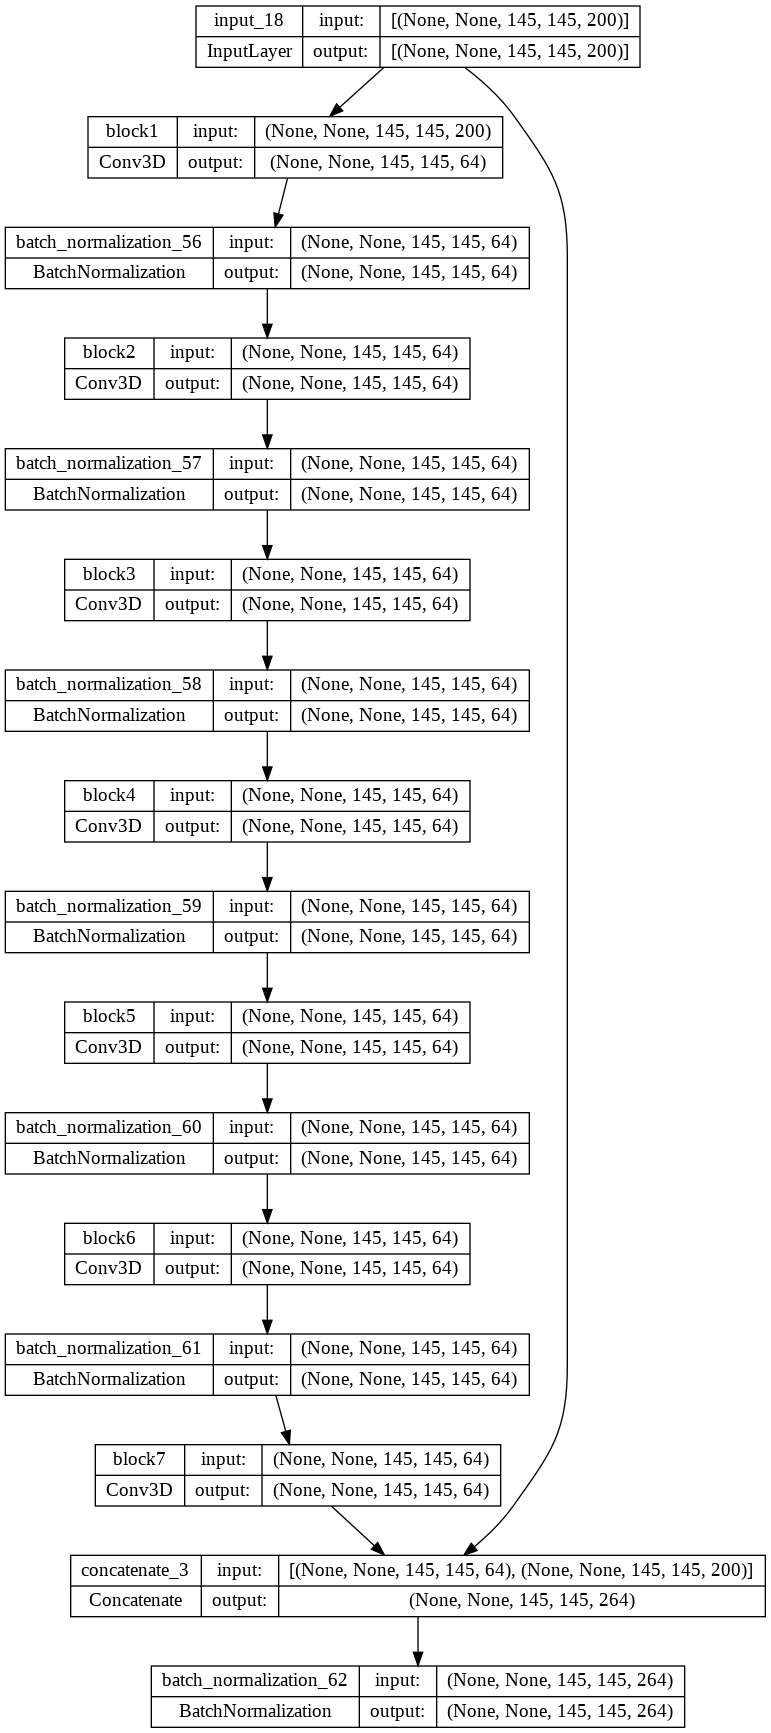

In [ ]:
# Show graph of the model
keras.utils.plot_model(mymodel, "my_model_graph.png", show_shapes=True)

# Model Hyperparameters

In [ ]:
# we need to build a custom loss function as specified in the paper
# since I don't have a custom loss function (very difficult to understand from paper), 
# so, I'm using binary_crossentropy 
custom_loss_fn = 'binary_crossentropy'

In [ ]:
# the paper mentions something about using quality assessment metrics: PSNR, SAM, ERGAS and SSIM
# I'm not sure what these mean
custom_metrics = None

In [ ]:
lr = 1e-3    # also try 3e-4 (aka karpathy's constant)
b1 = 0.9
b2 = 0.999
epsilon = 1e-8
weight_decay = 1e-4
# optimizer = tf.keras.optimizers.experimental.Adam(learning_rate=lr, weight_decay=weight_decay, 
#                                                   beta_1=b1, beta_2=b2, epsilon=epsilon)
optimizer = tf.keras.optimizers.experimental.Adam(learning_rate=lr, beta_1=b1, beta_2=b2, epsilon=epsilon)

epochs = 60
minibatch_size = 256

mycallback = ModelCheckpoint('HSI_MF_1.h5', save_best_only=True)

# we'll have to design a custom loss function as specified in the paper

# mymodel.compile(loss=custom_loss_fn, optimizer=optimizer, metrics=custom_metrics)
mymodel.compile(loss=custom_loss_fn, optimizer=optimizer)

In [ ]:
history = mymodel.fit(X, Y, batch_size=minibatch_size, epochs=epochs, verbose=0, 
                      callbacks=mycallback, validation_split=0.2)

ValueError: ignored